In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import shutil
import math
import time

from IPython.display import display
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
import numpy as np
import scipy as sp
import wfdb

In [26]:
class HPF():
    """First stage: Linear High Pass"""
    
    def __init__(self, M=5):
        self.b = -(np.ones(M) / M)
        self.b[int((M + 1) / 2)] += 1
        self.a = [1]
        self.nz = M - 1 # required "memory"
        
    def __call__(self, x, z=None):
        return sp.signal.lfilter(self.b, self.a, x, zi=z)
    
class LPF():
    """Second stage: Nonlinear Low Pass"""
    
    def __init__(self, M=30):
        self.M = M
        self.b = np.ones(M)
        self.a = [1]
        self.nz = M - 1
    
    def __call__(self, x, z=None):
        squared = x ** 2
        return sp.signal.lfilter(self.b, self.a, squared, zi=z)
    

class QRSDetector():
    """Filters signal and finds peak(s) for a segment"""
    
    def __init__(self, Mhp=5, Mlp=30, alpha=0.2, gamma=0.15, mode="conv", prom=0.5):
        self.hpf = HPF(Mhp)
        self.lpf = LPF(Mlp)
        self.alpha = alpha
        self.gamma = gamma
        self.mode = mode
        self.prom = prom
        
        self.thr = 0.01 # maybe determine dinamically?
        self.shift = int((Mhp + 1) / 2)
        self.hpz = np.zeros(self.hpf.nz)
        self.lpz = np.zeros(self.lpf.nz)
    
    def __call__(self, x):
        # STEP 1 and 2: hpf and lpf
        y, self.hpz = self.hpf(x, self.hpz)
        y, self.lpz = self.lpf(y, self.lpz)
        
        # STEP 3: decision-making
        y[y < self.thr] = 0
        if self.mode == "conv":
            peaks = np.arange(0, len(y))[np.convolve(y, [-1, 2 -1], "same") > 0]
        else:
            peaks, _ = sp.signal.find_peaks(y, prominence=self.prom)
        
        # remove multiple detections, useful when thr. has not yet been adapted
        peaks = remove_spurious(y, peaks)
        peakh = np.mean(y[peaks]) if len(peaks) > 0 else 2
        
        self.thr = self.alpha*self.gamma*peakh + (1 - self.alpha)*self.thr

        #peaks=None
        
        return y, peaks
    
def remove_spurious(sig, peaks):
    """Remove peak repeats, assuming fs=250"""
    thr = 50 #smaller than the distance between 2 heartbeats
    
    keptpeaks = []
    for i in range(0, len(sig), thr):
        cur_peaks = peaks[peaks >= i]
        cur_peaks = cur_peaks[cur_peaks < i+thr]
        if len(cur_peaks) == 0:
            continue
        pk = cur_peaks[np.argmax(sig[cur_peaks])]
        keptpeaks.append(pk)
    peaks = np.array(keptpeaks)
    
    to_rem = []
    for i in range(0, len(peaks)-1):
        if peaks[i+1] - peaks[i] < thr:
            if sig[peaks[i]] < sig[peaks[i+1]]:
                to_rem.append(i)
            else: to_rem.append(i+1)
    return np.delete(peaks, to_rem)
    
def detect_all(sig, detector, seglen=None, segsec=0.25, sr=250, verbose=True):
    if seglen is None:
        seglen = int(segsec * sr)
    fsig, peaks = np.zeros((0,)), np.zeros((0,)).astype(int)
    for segst in range(0, len(sig), seglen):
        if verbose and segst%100000 == 0: print(f"sample = {segst}")
        seg = sig[segst: segst+seglen]
        y, pks = detector(seg)
        fsig = np.concatenate([fsig, y])
        peaks = np.concatenate([peaks, pks + segst])
    
    return fsig, peaks


sample = 0


IndexError: arrays used as indices must be of integer (or boolean) type

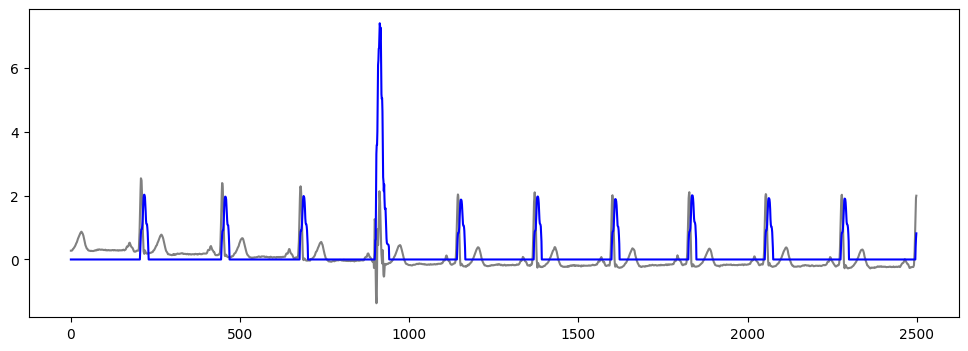

In [4]:
# RUN DETECTION ON THE FIRST 10 SECONDS OF S20011 in 100 SAMPLE SEGMENTS

record = wfdb.rdrecord("../data/20011/s20011", sampto=10*250)
fs = record.fs
sig = record.p_signal[:, 0]

detector = QRSDetector(Mhp=7, Mlp=15, alpha=0.2, gamma=0.15)
fsig, peaks = detect_all(sig, detector, 100)

figsize(12, 4)
t = np.arange(0, len(sig))
plt.plot(sig, color="gray")
plt.plot(t, fsig, "b")
plt.plot(peaks, fsig[peaks], "kx",)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
# plt.axvline(1300, color="r")
# plt.axvline(1400, color="r")
#plt.xlim((200, 300))

<IPython.core.display.Javascript object>


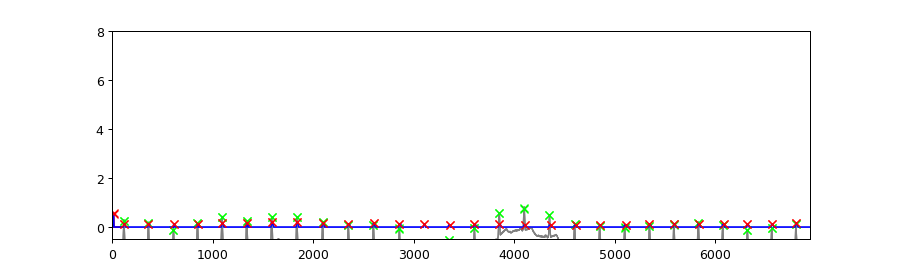

[]


In [86]:
# A DEMONSTRATION OF THE REAL-TIME DETECTION IN SMALL SEGMENTS

from functools import partial

def animate(sig, detector, seglen, limy=(-0.5, 8)):
    
    global fsig  # ugly hack but makes the anim work
    global peaks
    gfsig, gpeaks = np.zeros((0,)), np.zeros((0,)).astype(int)
    segs = np.arange(0, len(sig), seglen)
    
    figsize(10, 3)
    t = np.arange(0, len(sig))
    fig, ax = plt.subplots()
    ax.axis([0,len(t), limy[0], limy[1]])
    plot_ax, = ax.plot([],[], color="r") 
    peaks_ax, = ax.plot([], [], "kx", linewidth=2)
    vlines_ax = ax.vlines([], [], [])
    orig_ax, = ax.plot(t, sig, color="silver", linewidth=1)
    

    print(gpeaks)
    def anim_data(i):
        segst = segs[i]
        global fsig  # ugly hack but makes the anim work
        global peaks
        seg = sig[segst: segst+seglen]
        
        y, pks = detector(seg) # CALL THE DETECTOR FOR NEW SEGMENT
        
        fsig = np.concatenate([fsig, y])
        
        print(len(t), len(fsig), i, len(t[:segst+seglen]), len(fsig[:segst+seglen]))
        plot_ax.set_data(t[:segst+seglen], fsig[:segst+seglen])
        peaks_ax.set_data(segst+pks, fsig[segst+pks])
        #vlines_ax.set_data([segst, segst], limy[0], limy[1])

        time.sleep(0.3)
        
    global global_var
    #func = lambda i: anim_data(i, gfsig, gpeaks)
    global_var = matplotlib.animation.FuncAnimation(fig, anim_data, frames=len(segs))
    plt.show()

%matplotlib notebook

animate(sig, detector, 100)

In [20]:
# EVALUATION
%matplotlib inline
plt.clf()


def prepare_data(record_path, secto=None, sampto=None, pn_dir=None):
    """Reads record and return signal, annotated peaks"""
    
    header = wfdb.rdheader(record_path, pn_dir=pn_dir)
    fs = header.fs
    if secto is not None: sampto = secto * fs
    if sampto is not None: sampto = min(sampto, header.sig_len)
    record = wfdb.rdrecord(record_path, sampto=sampto, pn_dir=pn_dir)
    ann = wfdb.rdann(record_path, 'atr' , sampto=sampto, pn_dir=pn_dir)
    sig = record.p_signal[:, 0]
    beat_ann =["N", "L", "R", "B", "A", "a", "J", "S", "V", "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"]
    mask = np.isin(ann.symbol, beat_ann)
    truepks = np.array(ann.sample)[mask]
    
    # RESAMPLE TO 250 - a makeshift solution to avoid adaptive parameter tuning
    ratio = 250 / fs
    sig = sp.signal.resample(sig, int(len(sig) * ratio))
    truepks = (truepks * ratio).astype(int)
    truepks = remove_spurious(sig, truepks)
    return sig, truepks, 250, fs

def plot_all(sig, truepks, fsig=None, predpks=None, labels=False):
    "Plots original signal, filtered signal, peaks."
    
    figsize(12, 4)
    plt.plot(sig, color="gray", linewidth=1)
    plt.plot(truepks, sig[truepks], "x", color="lime")
    if labels:
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
    if fsig is not None:
        plt.plot(fsig, "b", linewidth=1)
        plt.plot(predpks, fsig[predpks], "rx")


def compare_true_pred(truepks, predpks, thr):
    """Slow? Computes TP, FP, FN counts."""
    TP, FP, FN = 0, 0, 0
    _predpks = predpks.copy()
    for tpk in truepks:
        FN += 1
        for i,ppk in enumerate(_predpks):
            if abs(tpk - ppk) < thr:
                TP += 1; FN -= 1
                _predpks = np.delete(_predpks, i)
                break
        
    FP = len(_predpks)
    return TP, FP, FN

def eval_all(truepks, predpks, thr):
    """Computes ppv and sensitivity score for predicted peaks."""
    TP, FP, FN = compare_true_pred(truepks, predpks, thr)
    ppv = TP / (TP + FP + 1e-10) # positive predictivity
    sensitivity = TP / (TP + FN + 1e-10)
    return ppv, sensitivity


def save_results(record_path, predpks, orig_fs):
    """Saves detections to an .asc annotation file."""
    rdir = os.path.dirname(record_path)
    rname = os.path.basename(record_path)
    # UPSAMPLE AGAIN
    ratio = orig_fs / 250
    predpks = (predpks * ratio).astype(int)
    symbols = np.full(len(predpks), "N")
    #wfdb.wrann(rname, "asc", predpks, symbol=symbols, write_dir=rdir)
    
    with open(os.path.join(rdir, rname + ".asc"), "w") as f:
        for peak in predpks:
            f.write(f"0:00:00.00 {peak} N 0 0 0\n")


<Figure size 1200x400 with 0 Axes>

sample = 0
[  10  115  358  616  847 1091 1337 1586 1841 2097 2349 2599 2857 3105
 3361 3603 3850 4111 4361 4611 4852 5111 5346 5590 5834 6085 6321 6563
 6809]
evaluating...
(0.965517241375981, 0.9999999999964286)


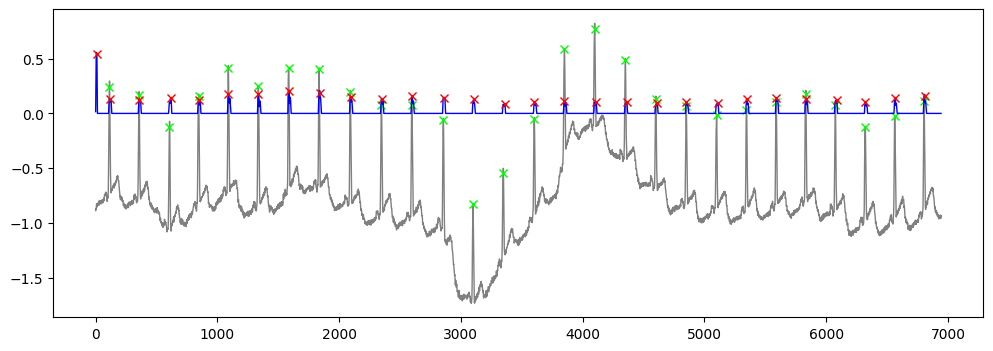

In [35]:
%matplotlib inline
plt.clf()

sig, truepeaks, fs, _ = prepare_data("121", sampto=10000, pn_dir="mitdb")
#sig, truepeaks, fs, _ = prepare_data('b001', sampto=200*250, pn_dir='cebsdb')
detector = QRSDetector(Mhp=7, Mlp=10, alpha=0.2, gamma=0.05, prom=0.05)
fsig, predpeaks = detect_all(sig, detector, seglen=1000, sr=fs)

print(predpeaks)

#fsig, _ = detector(sig[:10000])
#plt.plot(fsig)
#plt.plot(sig[:10000])
plot_all(sig, truepeaks, fsig, predpeaks)
print("evaluating...")
print(eval_all(truepeaks, predpeaks, 50))




In [36]:
# FULL SCRIPT - use .py file for command line usage

def qrs_detector_stack(record_path, secto=None, sampto=None, pn_dir=None, verbose=False):
    """Detects and evaluates detection for record at [record_path]"""
    
    sig, truepeaks, fs, orig_fs = prepare_data(record_path, secto=secto, sampto=sampto, pn_dir=pn_dir)
    
    #detector = QRSDetector(Mhp=7, Mlp=10, alpha=0.2, gamma=0.09, mode="conv")
    # OR USE SCIPY's FINDPEAKS WITH A PROMINENCE SETTING FOR DECISION STEP
    detector = QRSDetector(Mhp=7, Mlp=10, alpha=0.2, gamma=0.05, mode="findpeaks", prom=0.05)
    
    fsig, predpeaks = detect_all(sig, detector, seglen=1000, sr=fs, verbose=verbose)
    ppv, sensitivity = eval_all(truepeaks, predpeaks, 50)
    
    save_results(record_path, predpeaks, orig_fs)
    if verbose:
        print(f"ppv = {ppv:.4f}, sensitivity = {sensitivity:.4f}")
    return predpeaks, ppv, sensitivity
    
    
def eval_all_ltst():
    
    records = ["s20011", "s20021", "s20031", "s20041", "s20051", "s20061", "s20071", "s20081", "s20091", "s20101",
            "s20111", "s20121", "s20131", "s20141", "s20151", "s20161", "s20171", "s20181", "s20191", "s20201",
            "s20211", "s20221", "s20231", "s20241", "s20251", "s20261", "s20271", "s20272", "s20273", "s20274",
            "s20281", "s20291", "s20301", "s20311", "s20321", "s20331", "s20341", "s20351", "s20361", "s20371",
            "s20381", "s20391", "s20401", "s20411", "s20421", "s20431", "s20441", "s20451", "s20461", "s20471",
            "s20481", "s20491", "s20501", "s20511", "s20521", "s20531", "s20541", "s20551", "s20561", "s20571",
            "s20581", "s20591", "s20601", "s20611", "s20621", "s20631", "s20641", "s20651", "s30661", "s30671",
            "s30681", "s30691", "s30701", "s30711", "s30721", "s30731", "s30732", "s30741", "s30742", "s30751",
            "s30752", "s30761", "s30781", "s30791", "s30801"]
    
    allppv, allsens = [], []
    for record in records:
        print(f"Evaluating record {record} ...")
        _, ppv, sens = qrs_detector_stack(record, secto=1800, pn_dir="ltstdb")
        print(f"ppv = {ppv:.4f}, sens = {sens:.4f}")
        allppv.append(ppv); allsens.append(sens)
    
    print(f"mean_ppv={np.mean(allppv):.4f}, mean_sensitivity={np.mean(allsens):.4f}")
    
def eval_all_mit():
    
    records = ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
            "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
            "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
            "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
            "222", "223", "228", "230", "231", "232", "233", "234"]
    
    allppv, allsens = [], []
    for record in records[:]:
        print(f"Evaluating record {record} ...")
        _, ppv, sens = qrs_detector_stack(record, secto=1800, pn_dir="mitdb")
        print(f"ppv = {ppv:.4f}, sens = {sens:.4f}")
        allppv.append(ppv); allsens.append(sens)
    
    print(f"mean_ppv={np.mean(allppv):.4f}, mean_sensitivity={np.mean(allsens):.4f}")



eval_all_mit()

#eval_all_ltst()

Evaluating record 100 ...
ppv = 0.9996, sens = 0.9965
Evaluating record 101 ...
ppv = 0.9867, sens = 0.9968
Evaluating record 102 ...
ppv = 0.9927, sens = 0.9986
Evaluating record 103 ...
ppv = 0.9986, sens = 0.9966
Evaluating record 104 ...
ppv = 0.9259, sens = 0.9959
Evaluating record 105 ...
ppv = 0.9386, sens = 0.9949
Evaluating record 106 ...
ppv = 0.9897, sens = 0.9936
Evaluating record 107 ...
ppv = 0.8828, sens = 1.0000
Evaluating record 108 ...
ppv = 0.9255, sens = 0.9340
Evaluating record 109 ...
ppv = 0.9836, sens = 0.9996
Evaluating record 111 ...
ppv = 0.9971, sens = 0.9906
Evaluating record 112 ...
ppv = 0.9905, sens = 0.9925
Evaluating record 113 ...
ppv = 0.9889, sens = 0.9972
Evaluating record 114 ...
ppv = 0.9946, sens = 0.9920
Evaluating record 115 ...
ppv = 0.9995, sens = 0.9985
Evaluating record 116 ...
ppv = 0.9950, sens = 0.9917
Evaluating record 117 ...
ppv = 0.9947, sens = 0.9902
Evaluating record 118 ...
ppv = 0.9369, sens = 1.0000
Evaluating record 119 ...
pp